# Финальный проект. Промышленность.

# Содержание

1. [Описание проекта, его задачи и загрузка данных](#раздел-1)
2. [План проекта](#раздел-2)
3. [Исследовательский анализ данных](#раздел-3)
4. [Статистический анализ данных](#раздел-4)

   4.1 [Вывод по результатам исследования](#раздел-4-1)
   
5. [Предобработка данных](#раздел-5)

   5.1 [Исследование итогового датафрейма](#раздел-5-1)
   
   5.2 [Вывод по исследованию нового датафрейма:](#раздел-5-2)
   
6. [Поиск модели](#раздел-6)   

   6.1 [Итоговая модель. Вывод.](#раздел-6.1)
   
7. [Тестирование модели](#раздел-7) 

8. [Отчет по проекту](#раздел-8)



## <a name="раздел-1"></a> Описание проекта, его задачи и загрузка данных

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 
 
**Задачи проекта:**  
Вам предстоит построить модель, которая предскажет температуру стали.


**Описание этапа обработки**    

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).


In [1]:
# Импорт pandas для работы с данными в виде таблиц (DataFrame)
import pandas as pd
# Импорт matplotlib для создания графиков и визуализации данных
import matplotlib.pyplot as plt 
# Импорт seaborn для более высокоуровневые и красочные стили для графиков
plt.style.use('seaborn-pastel')
import seaborn as sns 
# Импорт numpy для работы с массивами и выполнения математических операций
import numpy as np 
# Импорт termcolor для изменения цвета текста в терминале
from termcolor import colored
# Для полного отображения столбцов
pd.options.display.max_columns = None # полностью отображаем столбцы
# управляем предупреждениями, которые могут появиться при выполнении кода
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from time import time

from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor


RANDOM_STATE = 110923

/var/folders/w8/whz827qx38v0ln9s213kypp00000gp/T/ipykernel_46255/4001069388.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


Загрузим данные

In [2]:
try:
    df_arc = pd.read_csv('datasets/data_arc_new.csv')
    df_bulk = pd.read_csv('datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('datasets/data_bulk_time_new.csv')
    df_gas = pd.read_csv('datasets/data_gas_new.csv')
    df_temp = pd.read_csv('datasets/data_temp_new.csv')
    df_wire = pd.read_csv('datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('datasets/data_wire_time_new.csv')
except: 
    df_arc = pd.read_csv('/datasets/data_arc_new.csv')
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
    df_temp = pd.read_csv('/datasets/data_temp_new.csv')
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

**Описание данных**  
Данные состоят из файлов, полученных из разных источников:  
data_arc_new.csv — данные об электродах;  
data_bulk_new.csv — данные о подаче сыпучих материалов (объём);  
data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);  
data_gas_new.csv — данные о продувке сплава газом;  
data_temp_new.csv — результаты измерения температуры;  
data_wire_new.csv — данные о проволочных материалах (объём);  
data_wire_time_new.csv — данные о проволочных материалах (время).  


Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.  

## <a name="раздел-2"></a> План проекта


1.	Проведем анализ данных в таблицах, создадим информативные визуализации и сделаем аналитические выводы.
2.	Отфильтруем таблицу на предмет выявления аномалий и возможных ошибок, и в случае их обнаружения выполним дополнительные проверки и, если необходимо, пересчитаем данные.
3.	Предобработка данных.
4.	Уберем записи, где отсутствуют необходимые целевые значения.
5.	Заполним пропущенные значения в соответствии с требованиями задачи.
6.	Совместим таблицы для создания окончательного набора данных, который будет использоваться для построения модели.
7.	Разделим выборку на обучающую и тестовую, обучим модель и проанализируем полученные результаты и метрики. 


В пункте 3 мы говорим о понятии адекватности данных. Важно пояснить, что адекватность данных (data adequacy) - это понятие, оценивающее, насколько данные, используемые в анализе, соответствуют задачам и целям, и могут быть использованы для получения достоверной информации и принятия обоснованных решений. Для нас очень важно, чтобы данные были достаточно точными, полными и представляли собой адекватное отражение исследуемого явления или процесса.

Адекватность конкретно нашего проекта заключается в том, чтобы убедиться, что данные о конечной температуре были измерены после завершения всех этапов нагрева и подачи материалов. Это важно для того, чтобы удостовериться, что данные отражают реальный результат процесса обработки металла. Если бы данные о конечной температуре были измерены до завершения всех этапов, то это могло бы исказить результаты и делать выводы на их основе неправильными. Таким образом, проверка адекватности в контексте данного проекта помогает удостовериться в корректности данных и надежности результатов исследования.


## <a name="раздел-3"></a> Исследовательский анализ данных



Создадим словарь datasets_dict, который ассоциирует названия данных с соответствующими объектами DataFrame. Это упростит доступ и управление нашими данными при анализе и обработке в дальнейшем. Мы сможем обращаться к данным по их названиям в словаре.

In [3]:
all_datasets = {
    'Данные об электродах': df_arc, 
    'Данные о подаче сыпучих материалов (объём)': df_bulk, 
    'Данные о подаче сыпучих материалов (время)': df_bulk_time,
    'Данные о продувке сплава газом': df_gas,
    'Результаты измерения температуры': df_temp,
    'Данные о проволочных материалах (объём)': df_wire,
    'Данные о проволочных материалах (время)': df_wire_time
}


Выведем название каждой таблицы (ключа в словаре datasets_dict) с использованием цвета и форматирования.

Затем отобразим первые 10 строк каждой таблицы с помощью display().

Затем выведем информацию о каждой таблице, включая типы данных и наличие пропущенных значений, снова с использованием display().

В конце добавим разделитель --------------------------- между каждой партией данных для улучшения читаемости вывода.

In [5]:
for data in all_datasets:
    print(colored(data, "blue", attrs=["bold"]))
    display(all_datasets[data].head(10))
    display(all_datasets[data].info())
    print('---------------------------')


Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

---------------------------
Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

---------------------------
Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

---------------------------
Данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

---------------------------
Результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

---------------------------
Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

---------------------------
Данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

---------------------------


***Какие промежуточные выводы мы можем сделать?***

**Данные об электродах (df_arc):**

- Эти данные предоставляют информацию о нагреве сырья в электродной дуге при выплавке стали.
- Всего имеется 14876 записей, и важно отметить, что данные не содержат пропущенных значений для ключевых столбцов: "key", "Начало нагрева дугой", "Конец нагрева дугой", "Активная мощность", и "Реактивная мощность".
- Из этих данных можно извлечь важную информацию о процессе нагрева, такую как распределение активной и реактивной мощности, длительность нагрева, и многое другое.
- Также, на основе данных о мощности, можно рассчитать полную мощность, и умножив её на время нагрева, получить информацию об энергии, которая может быть использована как дополнительная характеристика в модели.

**Данные о подаче сыпучих материалов (df_bulk) и времени их подачи (df_bulk_time):**

- Данные о подаче сыпучих материалов, которые используются для корректировки химического состава сплава.
- Всего имеется 3129 записей, и существует 15 различных видов сыпучих материалов, обозначенных как "Bulk 1" до "Bulk 15".
- Однако, важно отметить, что многие из этих столбцов имеют большое количество пропущенных значений, что может указывать на то, что конкретные сыпучие материалы не добавлялись во всех партиях.
- Возможно, пропущенные значения можно безопасно заполнить нулями, но это зависит от целей анализа.

**Данные о продувке сплава газом (df_gas):**

- Эти данные предоставляют информацию о продувке сплава газом.
- Всего имеется 3239 записей, и данные представлены в виде единственного столбца "Газ 1", который содержит значения объема продуваемого газа для каждой партии.
- Положительно то, что в данных нет пропущенных значений, но важно учесть, что предоставлены только общие объемы газа на ковш.

**Данные о замерах температуры (df_temp):**

- Эти данные содержат информацию о замерах температуры, и она является целевой метрикой.
- Всего имеется 18092 записи, но важно отметить, что в столбце "Температура" есть много пропущенных значений (14665 non-null).
- Эти пропуски могут потребовать дополнительной обработки, такой как заполнение средними значениями или интерполяция, чтобы не искажать результаты анализа.
- Также, возможно, необходимо будет удалить строки с пропущенными значениями, чтобы не вносить искажения в исследование.

**Данные о количестве проволоки разных типов (df_wire) и времени её подачи (df_wire_time):**

- Эти данные содержат информацию о количестве проволоки разных типов и времени её подачи.
- Всего имеется 3081 запись, и колонки "Wire 1" до "Wire 9" представляют объемы проволоки разных типов.
- Существуют многочисленные пропуски в этих данных, что может указывать на то, что некоторые типы проволоки не использовались в каждой партии.
- Данные о времени подачи проволоки могут быть полезными для анализа хронологии процесса и выявления зависимостей между временем подачи проволоки и другим


## <a name="раздел-4"></a> Проведем статистический анализ всех наших данных:

In [6]:
for data in all_datasets:
    print(colored(data, "green", attrs=["underline"])) 
    display(all_datasets[data].drop('key', axis=1).describe().T\
.style.background_gradient(cmap='cividis'))
    print('---------------------------')



Данные об электродах


,count,mean,std,min,25%,50%,75%,max
Активная мощность,14876.000000,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.000000,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


---------------------------
Данные о подаче сыпучих материалов (объём)


,count,mean,std,min,25%,50%,75%,max
Bulk 1,252.000000,39.242063,18.277654,10.000000,27.000000,31.000000,46.000000,185.000000
Bulk 2,22.000000,253.045455,21.180578,228.000000,242.000000,251.500000,257.750000,325.000000
Bulk 3,1298.000000,113.879045,75.483494,6.000000,58.000000,97.500000,152.000000,454.000000
Bulk 4,1014.000000,104.394477,48.184126,12.000000,72.000000,102.000000,133.000000,281.000000
Bulk 5,77.000000,107.025974,81.790646,11.000000,70.000000,86.000000,132.000000,603.000000
Bulk 6,576.000000,118.925347,72.057776,17.000000,69.750000,100.000000,157.000000,503.000000
Bulk 7,25.000000,305.600000,191.022904,47.000000,155.000000,298.000000,406.000000,772.000000
Bulk 8,1.000000,49.000000,nan,49.000000,49.000000,49.000000,49.000000,49.000000
Bulk 9,19.000000,76.315789,21.720581,63.000000,66.000000,68.000000,70.500000,147.000000
Bulk 10,176.000000,83.284091,26.060347,24.000000,64.000000,86.500000,102.000000,159.000000


---------------------------
Данные о подаче сыпучих материалов (время)


,count,unique,top,freq
Bulk 1,252,252,2019-05-03 17:42:46,1
Bulk 2,22,22,2019-05-07 15:39:35,1
Bulk 3,1298,1298,2019-05-03 20:40:25,1
Bulk 4,1014,1014,2019-05-03 11:28:48,1
Bulk 5,77,77,2019-05-07 15:19:17,1
Bulk 6,576,576,2019-05-03 19:09:15,1
Bulk 7,25,25,2019-05-07 18:11:01,1
Bulk 8,1,1,2019-07-08 17:14:53,1
Bulk 9,19,19,2019-05-14 11:57:58,1
Bulk 10,176,176,2019-05-06 07:54:02,1


---------------------------
Данные о продувке сплава газом


,count,mean,std,min,25%,50%,75%,max
Газ 1,3239.000000,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.995040


---------------------------
Результаты измерения температуры


,count,mean,std,min,25%,50%,75%,max
Температура,14665.000000,1590.722741,20.394381,1191.000000,1580.000000,1590.000000,1599.000000,1705.000000


---------------------------
Данные о проволочных материалах (объём)


,count,mean,std,min,25%,50%,75%,max
Wire 1,3055.000000,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.000000,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.000000,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.000000,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.000000,15.132000,nan,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.000000,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.000000,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.000000,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.000000,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


---------------------------
Данные о проволочных материалах (время)


,count,unique,top,freq
Wire 1,3055,3055,2019-05-03 11:06:19,1
Wire 2,1079,1079,2019-05-03 13:15:34,1
Wire 3,63,63,2019-05-04 04:34:27,1
Wire 4,14,14,2019-05-07 15:19:17,1
Wire 5,1,1,2019-08-13 06:14:30,1
Wire 6,73,73,2019-05-07 14:46:05,1
Wire 7,11,11,2019-07-27 05:49:05,1
Wire 8,19,19,2019-05-14 11:29:24,1
Wire 9,29,29,2019-05-04 17:21:27,1


---------------------------



**Данные об электродах:**

Активная мощность имеет среднее значение около 0.662752 и стандартное отклонение 0.258885. Значения активной мощности варьируются от 0.223120 до 1.463773.
Реактивная мощность имеет среднее значение около 0.438986 и стандартное отклонение 5.873485. В этой колонке есть выбросы, так как минимальное значение составляет -715.479924. Среднее значение может быть сильно искажено выбросами.

**Данные о подаче сыпучих материалов (объём):**  

Всего имеется 15 видов сыпучих материалов (Bulk 1, Bulk 2, ..., Bulk 15).
Разные виды сыпучих материалов имеют разный объем и разное распределение. Например, Bulk 12 имеет средний объем около 260.47, в то время как Bulk 1 имеет средний объем около 39.24.
Bulk 8 имеет только одно заполненное значение, что является все же неинформативным.

**Данные о подаче сыпучих материалов (время):**  

Эти данные предоставляют информацию о времени подачи сыпучих материалов для разных партий.
Каждый вид сыпучего материала имеет свою уникальную дату и время подачи. Время подачи может быть важным фактором при анализе влияния сыпучих материалов на процесс.

**Данные о продувке сплава газом:**  

Газ 1 имеет средний объем около 11.002062. В данных нет пропущенных значений.
Эти данные позволяют анализировать объем продувки газом для различных партий стали.

**Результаты измерения температуры:**  

Температура имеет среднее значение около 1590.722741 и стандартное отклонение 20.394381.
Присутствуют записи с минимальной температурой 1191.000000 и максимальной температурой 1705.000000. Температурные данные представлены в целых числах.

**Данные о проволочных материалах (объём):**

У нас есть 9 разных типов проволоки.
Объем проволоки разных типов имеет разные средние значения и стандартные отклонения. Например, Wire 1 имеет средний объем около 100.895853, в то время как Wire 7 имеет средний объем около 10.039007.

**Данные о проволочных материалах (время):**  

Эти данные предоставляют информацию о времени подачи проволоки разных типов.
Каждый тип проволоки имеет свою уникальную дату и время подачи. 


**Изучим более подробно ситуацию с Активной и Реактивной мощностью (таблица  df_arc)** 

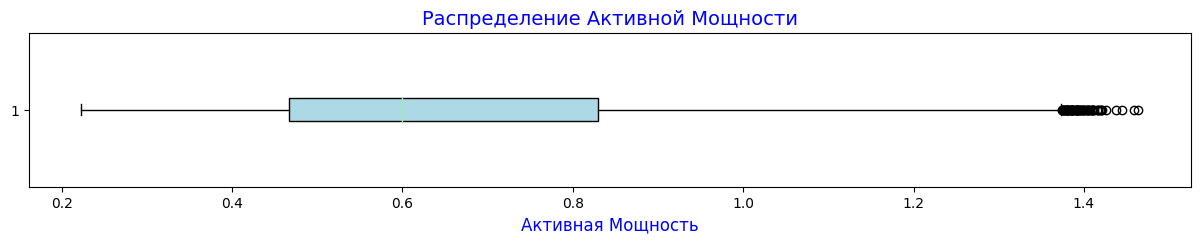

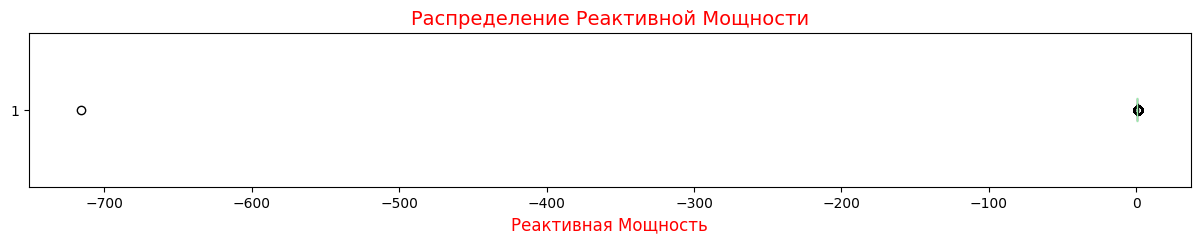

In [7]:
# Рисуем боксплот для активной мощности
plt.figure(figsize=(15, 2))
plt.title('Распределение Активной Мощности', fontsize=14, color='blue')
plt.xlabel('Активная Мощность', fontsize=12, color='blue')
plt.boxplot(df_arc['Активная мощность'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.show()

#  Рисуем боксплот для реактивной мощности
plt.figure(figsize=(15, 2))
plt.title('Распределение Реактивной Мощности', fontsize=14, color='red')
plt.xlabel('Реактивная Мощность', fontsize=12, color='red')
plt.boxplot(df_arc['Реактивная мощность'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.show()


Наблюдаем отрицательные значения, чего по идее не должно быть. Уточним этот вопрос чуть позже, а пока отфильтруем DataFrame df_arc, оставляя только те строки, где значение "Реактивной мощности" больше или равно нулю. То есть удалим строки с отрицательными значениями "Реактивной мощности".

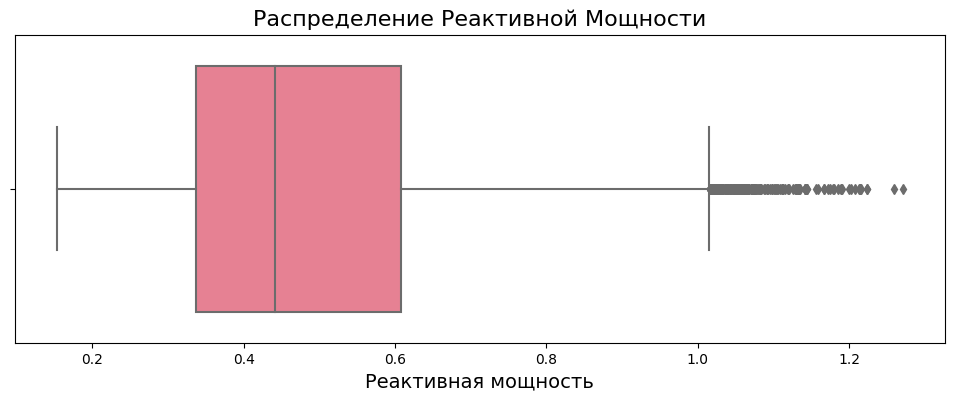

In [8]:
# Создаем копию исходного датафрейма df_arc_copy
df_arc_copy = df_arc.copy()

# Фильтруем данные в копии датафрейма
df_arc_copy = df_arc_copy[df_arc_copy['Реактивная мощность'] >= 0]

# Создаем фигуру и оси для визуализации
plt.figure(figsize=(12, 4))
plt.title('Распределение Реактивной Мощности', fontsize=16)
plt.xlabel('Реактивная Мощность', fontsize=14)
sns.boxplot(data=df_arc_copy, x='Реактивная мощность', orient='h', palette='husl')
plt.show()




Ситуация в корне поменялась. Идем дальше.   
 
Попробуем изучить плотность распределения. Это может помочь нам определить, нужна ли предобработка данных, такая как устранение выбросов или нормализация.

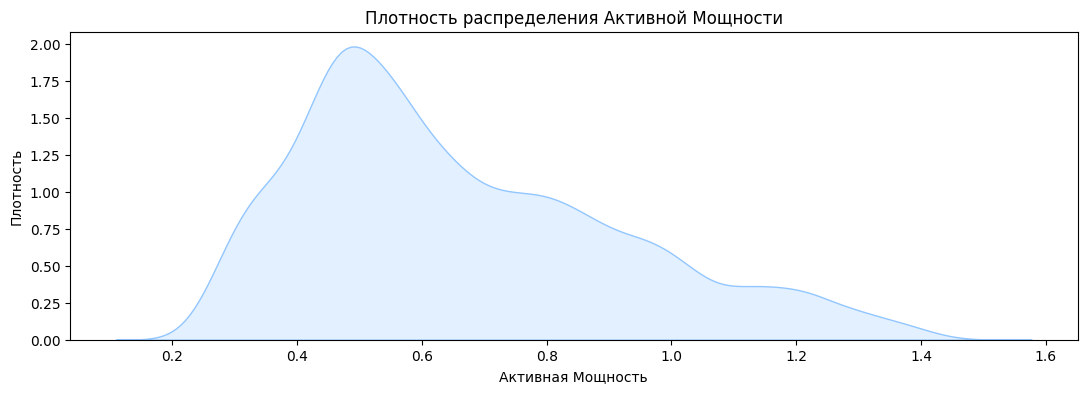

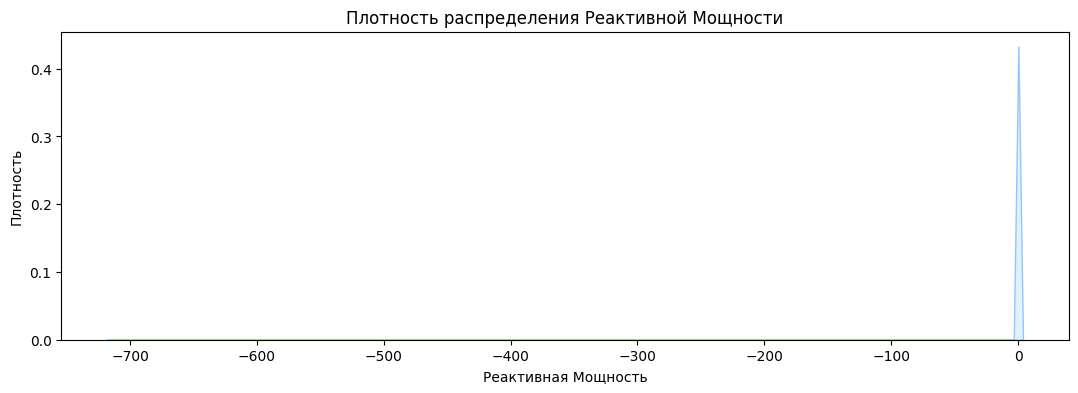

In [9]:
# Построим график плотности для активной мощности
plt.figure(figsize=(13, 4))
sns.kdeplot(df_arc['Активная мощность'], shade=True)
plt.title('Плотность распределения Активной Мощности')
plt.xlabel('Активная Мощность')
plt.ylabel('Плотность')
plt.show()

# Построим график плотности для реактивной мощности
plt.figure(figsize=(13, 4))
sns.kdeplot(df_arc['Реактивная мощность'], shade=True)
plt.title('Плотность распределения Реактивной Мощности')
plt.xlabel('Реактивная Мощность')
plt.ylabel('Плотность')
plt.show()



**Исследование выбросов:** на графиках видно, что активная и реактивная мощность имеют значения, выходящие за пределы типичного распределения. Эти точки могут быть выбросами, исследование которых может быть важным для понимания процесса. Рекомендую провести более подробный анализ этих выбросов.

**Потенциальные причины:** Чтобы более полно понять, почему наблюдаются такие аномалии в мощности, заказчику стоит обратить внимание на конкретные процессы и события, которые могли привести к этим значениям. Возможно, это связано с особенностями технологического процесса, внешними воздействиями или другими факторами.

**Дополнительные измерения:** Можно порекомендовать заказчику провести дополнительные измерения и мониторинг для выяснения, повторяются ли такие аномалии в разные периоды времени или они единичные, быть может ответы уже есть и это всего лишь часть технологического процесса. В противном случае, заказчик может разработать стратегии для предотвращения таких аномалий.

**Статистический анализ:** Можно также предложить провести статистический анализ, чтобы определить, какие значения мощности являются статистически значимыми выбросами. Это поможет отделить случайные аномалии от системных изменений.


**Рассмотрим таблицы подачи материалов при плавке (df_bulk):**


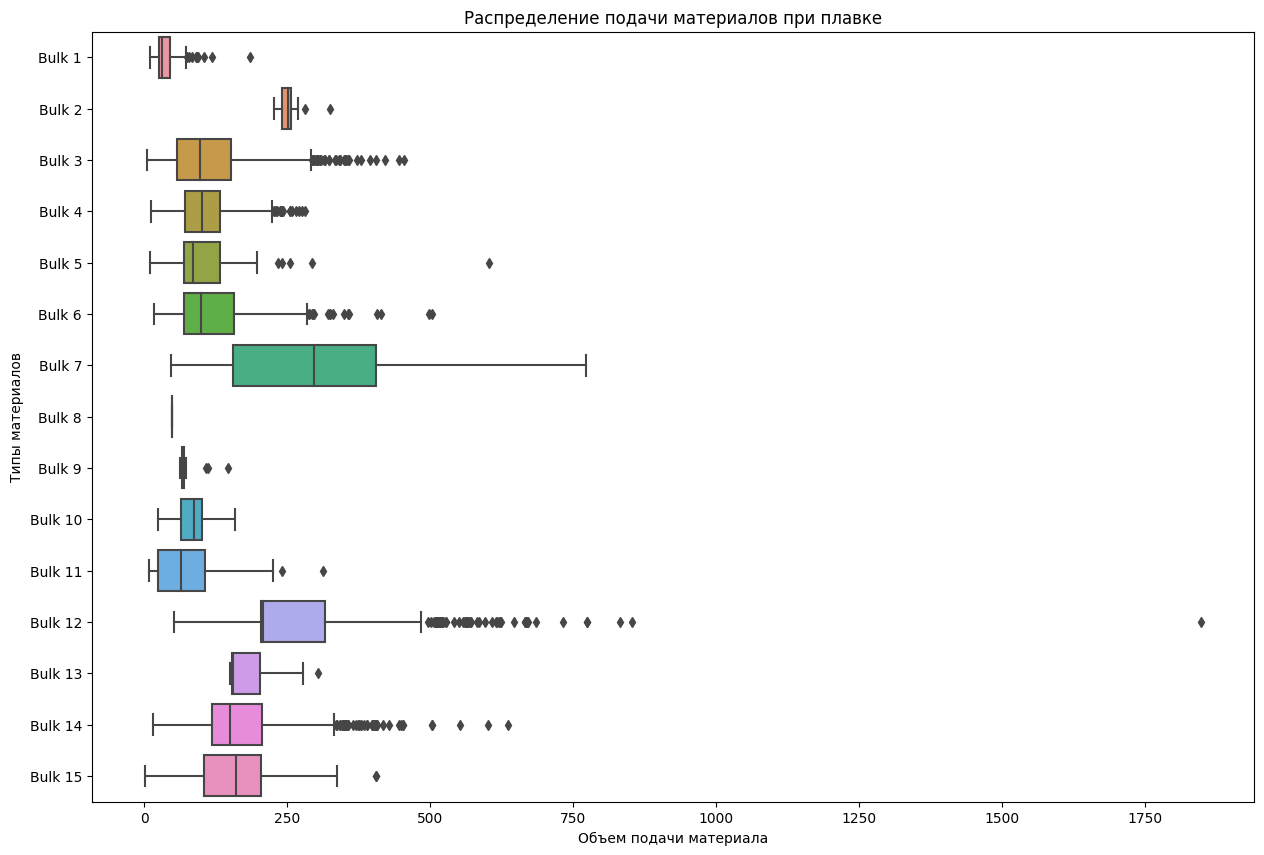

In [10]:
# Убираем столбец 'key' из данных
columns_to_plot = [col for col in df_bulk.columns if col != 'key']

# Создаем фигуру и оси
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=df_bulk[columns_to_plot], orient='h')

# Настраиваем внешний вид графика
plt.title('Распределение подачи материалов при плавке')
plt.xlabel('Объем подачи материала')
plt.ylabel('Типы материалов')

# Выводим график
plt.show()


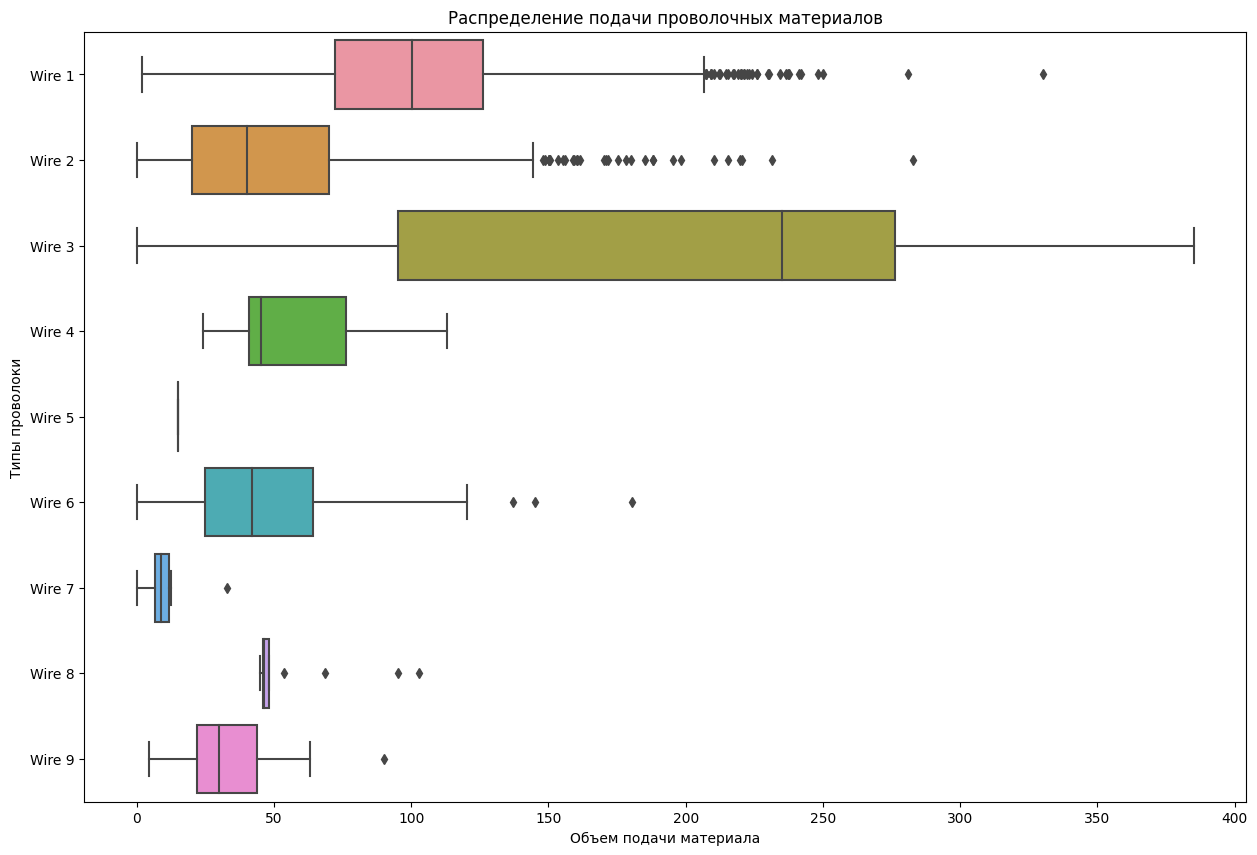

In [11]:
# Убираем столбец 'key' из данных
columns_to_plot = [col for col in df_wire.columns if col != 'key']

# Создаем фигуру и оси
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=df_wire[columns_to_plot], orient='h')

# Настраиваем внешний вид графика
plt.title('Распределение подачи проволочных материалов')
plt.xlabel('Объем подачи материала')
plt.ylabel('Типы проволоки')

# Выводим график
plt.show()


**Анализ выбросов и редких значений:**

***В таблице df_bulk:***

При анализе данных в таблице df_bulk обнаружено следующее:
- Почти все столбцы имеют небольшие выбросы, которые находятся за пределами "усов" (пределов размаха).
- Bulk 8 добавлялись всего лишь один раз. Возможно, такие редкие данные можно проигнорировать, так как они могут не оказывать значительного влияния на модель.
- В столбце Bulk 12 есть аномально большое значение. Рассматривается возможность исключения данной строки из анализа, чтобы избежать искажения результатов модели.

***В таблице df_wire:***

При анализе данных в таблице df_wire обнаружено следующее:
- Почти все столбцы также содержат небольшие выбросы, выходящие за пределы "усов".
- В столбцах Wire 1 и Wire 2 присутствуют аномальные значения. Рассматривается возможность исключения соответствующих строк из анализа, чтобы улучшить точность модели.
- Wire 5 добавлялись всего лишь один раз. Возможно, такие редкие данные можно проигнорировать.

***Общий вывод:***

Подводя итог, стоит обратить внимание на следующие моменты:
- Существуют материалы, которые добавлялись крайне редко. Необходимо рассмотреть, как исключение таких столбцов может повлиять на модель.
- Следует определить максимальное количество материала, которое добавляется, и рассмотреть исключение данных, считаемых выбросами.
- Пропущенные значения в данных можно безопасно заполнить значением 0.
- Необходимо уточнить возможность использования итогового объема материалов и оценить, как это может повлиять на конечную модель.

Возможно эти действия помогут обеспечить более надежный и точный анализ данных и построение более эффективной модели.


**Исследуем подачу газа:**

Сплавы, металлические материалы, состоящие из смеси двух или более металлов, часто подвергаются продувке инертным газом в процессе их обработки или производства по нескольким важным причинам:  

Защита от окисления: Инертные газы, такие как аргон или азот, не вступают в химические реакции с металлами при нормальных условиях и не способствуют их окислению во время нагрева. Под действием высоких температур металлы могут подвергаться окислительным процессам, что может сказаться на качестве и свойствах сплава. Продувка инертным газом создает защитную атмосферу, которая предотвращает взаимодействие металла с кислородом из воздуха.  

Улучшение качества: Продувка инертным газом также способствует удалению нежелательных примесей и газов из сплава. Например, при производстве стали, инертный газ может помочь устранить избыток углерода и другие легкоокисляемые элементы, что влияет на финальные свойства материала.  
 
Контроль химических реакций: В некоторых случаях инертные газы используются для управления химическими реакциями, происходящими в сплаве. Это дает возможность контролировать состав сплава и его свойства.  

Предотвращение образования газовых пузырей: В процессе плавки и формования металлов могут образовываться газовые пузыри. Продувка инертным газом способствует вытеснению этих газов из металлической матрицы, что предотвращает образование пустот и дефектов в структуре сплава.  

В целом, продувка инертным газом представляет собой критически важный технологический процесс, который способствует улучшению качества и свойств металлических сплавов во время их обработки и производства. Этот процесс позволяет предотвратить негативное воздействие окисления, улучшить чистоту сплава и обеспечить более надежный контроль производственных процессов.  

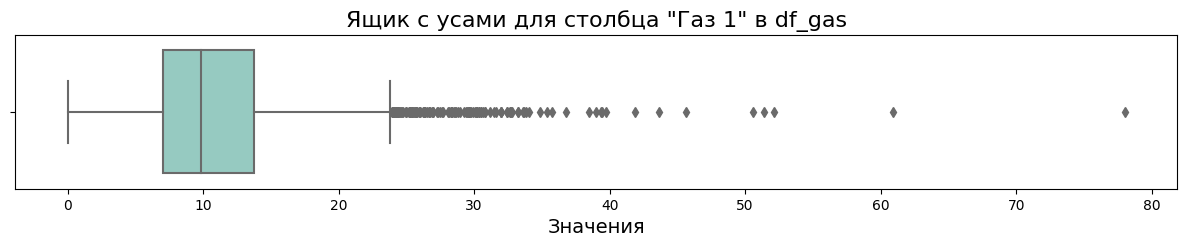

In [12]:
# Создаем фигуру и оси
plt.figure(figsize=(15, 2))
ax = sns.boxplot(data=df_gas, x='Газ 1', orient='h', palette='Set3')
ax.set_title('Ящик с усами для столбца "Газ 1" в df_gas', fontsize=16) # Заголовок
ax.set_xlabel('Значения', fontsize=14) # Метка по оси X
plt.show()


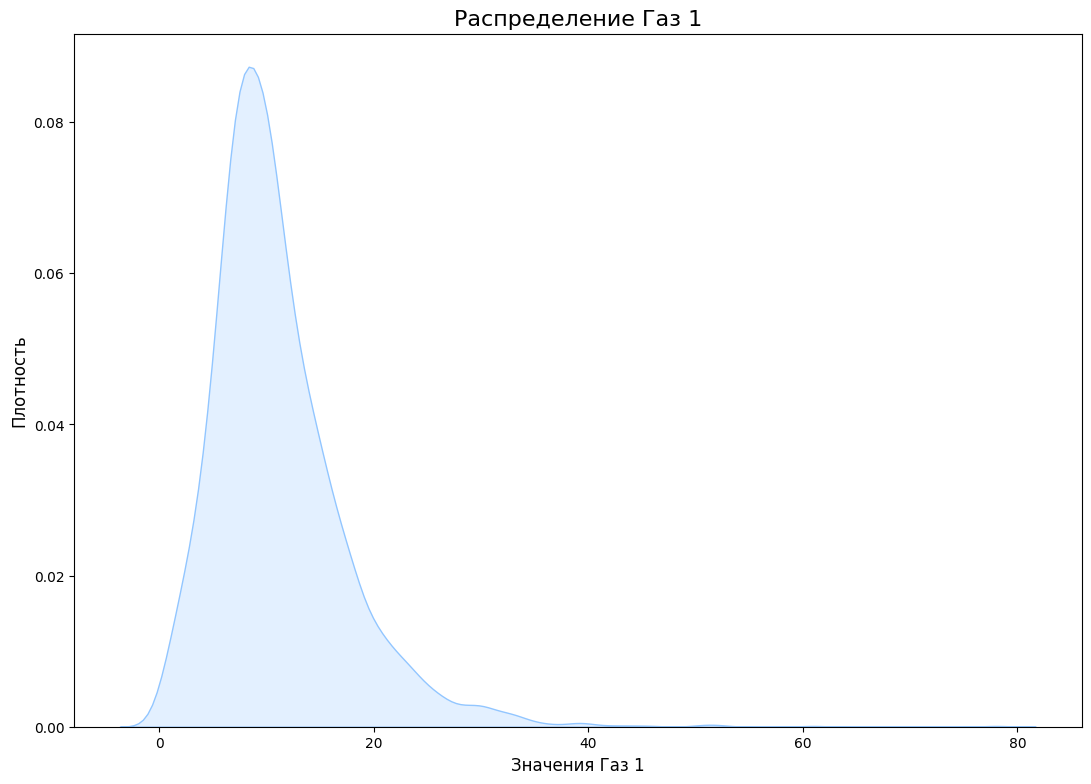

In [13]:
# Создаем фигуру с заданными размерами
plt.figure(figsize=(13, 9))

# Строим KDE график 
sns.kdeplot(df_gas['Газ 1'], shade=True)

# Настраиваем внешний вид
plt.title('Распределение Газ 1', fontsize=16)
plt.xlabel('Значения Газ 1', fontsize=12)
plt.ylabel('Плотность', fontsize=12)

# Отображаем график
plt.show()



Исходя из графиков:

В подаче газа есть выбросы, предположительно значения выше 35-40. Причиной этому могут быть разные факторы:
 - Потенциальные неисправности оборудования
 - Несоответствие стандартам
 - Изменения в производственных условиях
 - Потенциальные потери и затраты
 - Безопасность
 - Потенциальные изменения в качестве продукции  
 
В любом случае данный момент лучше прояснить с заказчиком.

**Рассмотрим измерение температуры:**

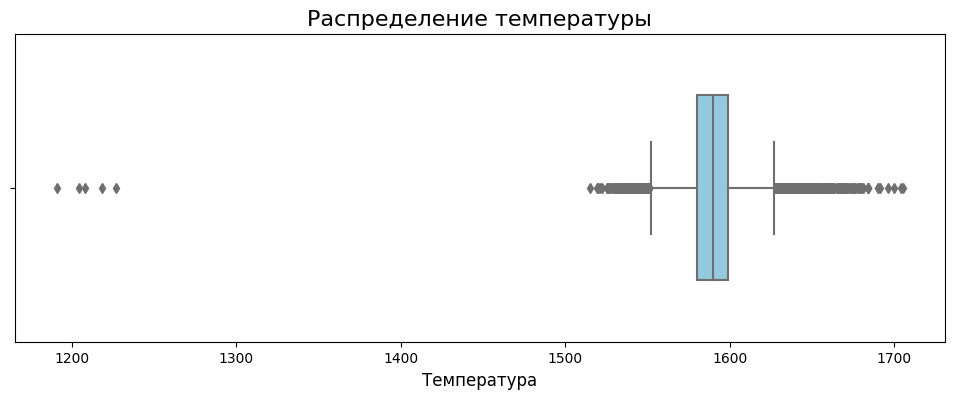

In [14]:
# Создаем фигуру с заданными размерами
plt.figure(figsize=(12, 4))
# Строим ящик с усами
ax = sns.boxplot(x='Температура', data=df_temp, orient='h', color='skyblue', width=0.6)
# Настраиваем внешний вид
plt.title('Распределение температуры', fontsize=16)
plt.xlabel('Температура', fontsize=12)
plt.ylabel('')
# Отображаем график
plt.show()




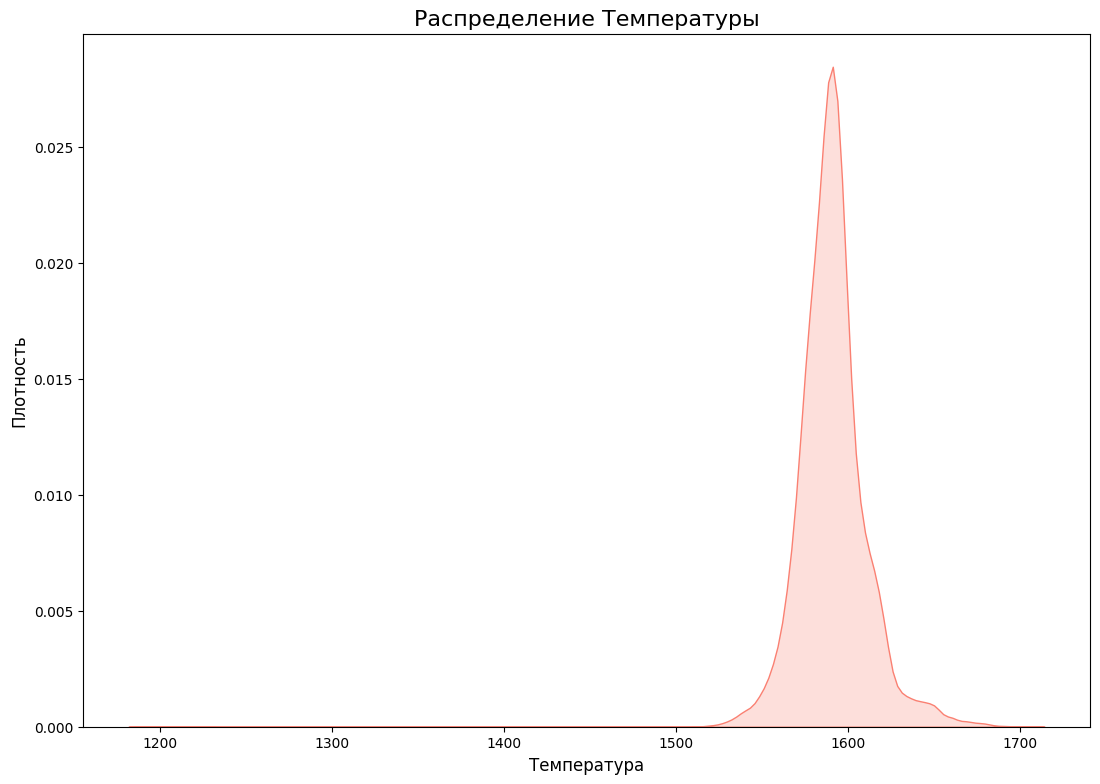

In [15]:
# Создаем фигуру с заданными размерами
plt.figure(figsize=(13, 9))

# Строим KDE график с заливкой
sns.kdeplot(df_temp['Температура'], shade=True, color='salmon')

# Настраиваем внешний вид
plt.title('Распределение Температуры', fontsize=16)
plt.xlabel('Температура', fontsize=12)
plt.ylabel('Плотность', fontsize=12)

# Отображаем график
plt.show()


Поскольку температура плавления стали находится в диапазоне от 1350 до 1535°С, то я бы ориентировалась именно на эти цифры и значения, которые ниже 1350 просто отбросила бы.

### <a name="раздел-4-1"></a> Вывод по результатам исследования:

- В некоторых таблицах присутствуют данные, которые могут быть считаны выбросами. Эти выбросы могут исказить результаты модели, и их следует учитывать при анализе данных и построении модели.

- Обнаружены пустые строки в целевом значении. Эти пропущенные данные должны быть обработаны, например, путем заполнения их средними или медианными значениями или нулями, чтобы обеспечить надежную обучаемость модели.

- Существуют материалы для плавления, которые добавлялись очень редко. Следует рассмотреть возможность исключения таких материалов из данных, чтобы улучшить производительность модели.

- Необходимо определить максимальное количество материала, которое добавляется, и рассмотреть исключение данных, которые могут считаться выбросами или аномалиями.

- В таблицах с данными о добавлении материалов присутствуют пропущенные значения, которые можно заполнить нулями для упрощения анализа.

- Следует уточнить возможность использования итогового объема материалов и оценить, как это может повлиять на конечную модель.

- В данных о подаче газа выявлены значения, которые могут считаться выбросами, особенно значения выше 40. Рекомендуется уточнить у заказчика, являются ли эти значения реальными или аномальными.

- Температурные данные также содержат значения, которые могут считаться аномальными. Значения сильно ниже температуры плавления стали можно считать аномалиями и исключить из анализа, а значения выше 1350 градусов можно оставить для улучшения точности модели.





***Вопросы к заказчику:***

Вопросов к заказчику не имею. Созвон прошел на высшем уровне, информация исчерпывающая.

С уважением,
Ксения.


## <a name="раздел-5"></a> Проведем предобработку данных


Уберем записи, где отсутствуют необходимые целевые значения.

Таблицу df_temp с целевой метрикой преобразуем и найдем целевую - последнее измерение температуры, а так же сохраним данные о первом измерении, как дополнительном параметре:

Для удобства займемся каждой таблицей по-отдельности

Начнем с температуры:

In [16]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Находим партии, где есть пропуски в данных - удаляем

In [17]:
# Смотри партии с пропусками
df_temp[df_temp['Температура'].isnull()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [18]:
# Смотрим пропуски 
last_temp = df_temp.groupby(['key'])['Температура'].agg('max').reset_index()
last_temp.rename(columns={'Температура': 'Последняя_температура'}, inplace=True)

last_temp['Последняя_температура'].value_counts(dropna=False)


Последняя_температура
1595.0    106
1594.0    103
1593.0     96
1598.0     93
1597.0     90
         ... 
1669.0      1
1675.0      1
1656.0      1
1705.0      1
1542.0      1
Name: count, Length: 146, dtype: int64

Пропуски решено удалить

In [19]:
# Находим партии с пропусками в данных
keys_with_null_values = df_temp[df_temp.isnull().any(axis=1)]['key']

# Удаляем все партии
df_temp = df_temp[~df_temp['key'].isin(keys_with_null_values)]

df_temp.info()


<class 'pandas.core.frame.DataFrame'>
Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13926 non-null  int64  
 1   Время замера  13926 non-null  object 
 2   Температура   13926 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 435.2+ KB


Опционально находим партии, где есть только одно значение - удаляем! Посмотрим, какое колличество раз происходил замер:

In [20]:
df_temp['key'].value_counts(ascending=True).head()

key
279     1
195     1
247     2
1268    2
614     2
Name: count, dtype: int64

In [21]:
# Удаляем партии с одним замером
df_temp = df_temp[df_temp.duplicated(subset='key', keep=False)]

df_temp.info()
df_temp['key'].value_counts(ascending=True).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 13924 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13924 non-null  int64  
 1   Время замера  13924 non-null  object 
 2   Температура   13924 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 435.1+ KB


key
1169    2
977     2
1914    2
2112    2
1535    2
556     2
1369    2
661     2
1974    2
343     2
Name: count, dtype: int64

In [22]:
# Смотрим статистику
df_temp['Температура'].describe()

count    13924.000000
mean      1590.802356
std         19.846423
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

Находим партии, где есть низкие температуры - удаляем эти партии.

In [23]:
# Удаляем партии с низкой температурой
df_temp = df_temp.groupby('key').filter(lambda group: (group['Температура'] >= 1350).all())


Оценим наши изменения на графике:

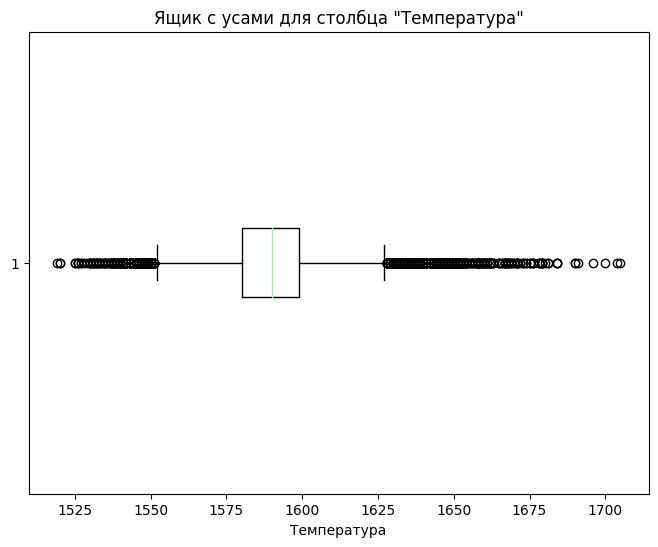

In [24]:
# Выбираем столбец 'Температура' для построения гистограммы ящика с усами
temperature_data = df_temp['Температура']

# Создаем ящик с усами
plt.figure(figsize=(8, 6))
plt.boxplot(temperature_data, vert=False)
plt.title('Ящик с усами для столбца "Температура"')
plt.xlabel('Температура')
plt.show()


In [25]:
df_temp.describe()

,key,Температура
count,13903.000000,13903.000000
mean,1243.470474,1590.924549
std,719.345817,18.751262
min,1.000000,1519.000000
25%,623.000000,1580.000000
50%,1246.000000,1590.000000
75%,1870.000000,1599.000000
max,2499.000000,1705.000000


Теперь данные имеют нормальное распределение.

Применяем агрегацию, находим первый и последний замер

In [26]:
# Преобразуем столбец 'Время замера' в формат даты и времени
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
# Группируем данные по столбцу 'key' и находим максимальное значение времени замера для каждой группы
df_temp_last = df_temp.groupby('key').agg('max')['Время замера']
df_temp_last = pd.DataFrame(df_temp_last)

In [27]:
# Объединяем результат с исходным df_temp по столбцу 'Время замера' с использованием левого объединения (left join)
df_temp_last = df_temp_last.merge(df_temp, on='Время замера', how='left')
# Получаем таблицу с колонками 'time_last', 'key', и 'temp_last'
df_temp_last.columns = ['time_last', 'key', 'temp_last']
df_temp_last.head()

,time_last,key,temp_last
0,2019-05-03 11:30:38,1,1613.0
1,2019-05-03 11:55:09,2,1602.0
2,2019-05-03 12:35:57,3,1599.0
3,2019-05-03 12:59:47,4,1625.0
4,2019-05-03 13:36:39,5,1602.0


In [28]:
# Группируем данные по столбцу 'key' и находим минимальное значение времени замера для каждой группы
df_temp_first = df_temp.groupby('key').agg('min')['Время замера']
df_temp_first = pd.DataFrame(df_temp_first)

In [29]:
# Объединяем результат с исходным df_temp по столбцу 'Время замера' с использованием левого объединения (left join)
df_temp_first = df_temp_first.merge(df_temp, on='Время замера', how='left')
# Получаем таблицу с колонками 'time_last', 'key', и 'temp_first'
df_temp_first.columns = ['time_first', 'key', 'temp_first']

In [30]:
# Объединяем таблицы df_temp_first и df_temp_last по столбцу 'key' с использованием левого объединения (left join) 
df = df_temp_first.merge(df_temp_last, on='key', how='left')\
                  .reindex(columns=['key', 'time_first', 'temp_first', 'time_last', 'temp_last'])

In [31]:
# Сохраним список с пустыми значениями целевой метрики
а = list(df[df['temp_last'].isna()]['key'])
# И без пустых значений
keys_not_na = list(df[~df['temp_last'].isna()]['key'])

# Смотрим таблицу
df.head(10)

,key,time_first,temp_first,time_last,temp_last
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
5,6,2019-05-03 13:46:41,1543.0,2019-05-03 14:11:38,1596.0
6,7,2019-05-03 14:16:36,1586.0,2019-05-03 14:45:40,1599.0
7,8,2019-05-03 14:53:46,1577.0,2019-05-03 15:20:41,1598.0
8,9,2019-05-03 15:36:33,1587.0,2019-05-03 16:06:44,1592.0
9,10,2019-05-03 16:13:59,1574.0,2019-05-03 16:39:50,1593.0


In [32]:
df['temp_last'].isna().sum()
739


739

In [33]:
# Приведем данные в целочисленный формат
df['time_first'] = (df['time_first']).astype(int)
df['time_last'] = (df['time_last']).astype(int)

Поработаем над датафреймом df_arc. Избавимся от отрицательной мощности.


In [35]:
# Находим номера партий, в которых есть отриц. реактивная мощность
keys_with_negative = df_arc[df_arc['Реактивная мощность'] < 0]['key'].unique()

# Удаляем эти партии
df_arc = df_arc[~df_arc['key'].isin(keys_with_negative)]


In [36]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.662753,0.487112
std,934.661090,0.258916,0.197623
min,1.000000,0.223120,0.153777
25%,806.000000,0.467114,0.337175
50%,1616.000000,0.599587,0.441667
75%,2429.000000,0.830314,0.608201
max,3241.000000,1.463773,1.270284


Добавим дополнительные параметры, перед тем, как объединять таблицы.

А так же удалим те параметры, которые будут коррелировать с остальными на более, чем 0.8 по коэффициенту Пирсона.

Данные об электродах:  

Дополним расчет полным временем нагрева, а так же посчитаем энергию - время нагрева * на полную мощность.

Исходя из физических принципов, полная мощность (S) рассчитывается по следующей формуле:

$$
S = \sqrt{Q^2 + p^2}
$$

Где:
- S - полная мощность.
- Q - активная мощность.
- p - реактивная мощность.
 
Мы также проведем расчет полного времени нагрева и вычислим энергию, которая представляет собой произведение времени нагрева на полную мощность:

Энергия = Время нагрева × Полная мощность

Эти вычисления позволят нам более полно охарактеризовать данные и использовать их для анализа и прогнозирования.

In [37]:
# Преобразуем столбцы 'Конец нагрева дугой' и 'Начало нагрева дугой' в формат даты и времени
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

# Вычисляем разницу между датами и временем и приводим к целочисленному формату
df_arc['Время нагрева'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.total_seconds().astype(int)
# Рассчитываем полную мощность 'Полная мощность'
df_arc['Полная мощность'] = (df_arc['Активная мощность'] ** 2 + df_arc['Реактивная мощность'] ** 2) ** 0.5
# Рассчитываем энергию
df_arc['Энергия'] = df_arc['Время нагрева'] * df_arc['Полная мощность']
df_arc.head(10)



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,159.830252
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137,0.440239,60.312695
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338,0.332731,112.463079
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126,0.860064,108.368056
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210,0.955315,200.616176
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280,1.373863,384.681584


Создадим сводную таблицу, в которой мы соберем общую сумму времени нагрева и энергии для каждой партии. Это будет полезной информацией, которую мы включим в итоговую таблицу и которая поможет нам более полно охарактеризовать процесс нагрева и его эффективность для каждой партии стали.

In [38]:
# Вычислим сумму дельт времени для каждой группы
df_arc_keys = df_arc.groupby('key').agg({
    'Время нагрева': np.sum,
    'Энергия': np.sum,
    'Полная мощность': np.sum
}).reset_index()

# Теперь df_arc_keys содержит сумму дельт времени для каждой группы
df_arc_keys.head(10)

,key,Время нагрева,Энергия,Полная мощность
0,1,1098,770.282114,3.718736
1,2,811,481.760005,2.588349
2,3,655,722.837668,5.019223
3,4,741,683.455597,3.400038
4,5,869,512.169934,2.816980
5,6,952,839.231310,3.313074
6,7,673,613.576982,3.283913
7,8,913,619.129542,3.405956
8,9,625,570.113675,4.335261
9,10,825,533.482050,3.791005


Обсудим различные ***стратегии работы*** с данными по добавленным материалам в партии стали. У нас есть несколько вариантов:

1. Использовать все столбцы материалов в модели: Этот подход означает, что мы включим все материалы, добавленные в партии, в нашу модель. Однако, это может привести к большому числу признаков и усложнению модели.

2. Рассчитать общую сумму добавления материалов Wire и Bulk и добавить итог в общую таблицу: Здесь мы можем упростить данные, объединив информацию о суммарном добавлении проволоки (Wire) и сыпучих материалов (Bulk) в один признак. Это позволит сократить количество признаков, но при этом сохранить важные данные.

3. Убрать редко добавляемые материалы и оставить остальные: Этот вариант предполагает удаление материалов, которые добавлялись в партии редко. Таким образом, мы сокращаем размерность данных и упрощаем модель.

4. Рассчитать сумму по редким материалам, а оставшиеся материалы оставить без изменений: Здесь мы можем сохранить информацию о редко добавляемых материалах, вычислив их суммарное количество, и оставить остальные материалы без изменений.

5. Рассчитать сумму по редким материалам и добавить параметр, указывающий количество добавок в партии: Этот вариант предполагает не только вычисление суммы редко добавляемых материалов, но и добавление дополнительного признака, который указывает на общее количество добавок в данной партии. Это может быть полезным для моделирования.

Для начала, мы можем применить пятый пункт и посмотреть, какие результаты даст модель при такой обработке данных. Этот подход позволит учесть как сумму редких материалов, так и общее количество добавок, что может быть информативным для моделирования.

In [39]:
def make_new_df(data, name):
    
    col_for_sum = []

    for col in data:
        if data[col].isna().sum() >= (len(data) - 1000):
            col_for_sum.append(col)
    
    data[f'count_{name}'] = data.drop('key', axis=1).count(axis=1)
    
    data[f'sum_{name}'] = data[col_for_sum].sum(axis=1)
    
    col_lasted = [col for col in data.columns if col not in col_for_sum]
    
    data = data[col_lasted].fillna(0)
    
    return data

Создадим два новых датафрейма: bulk и wire, с использованием функции make_new_df для предварительной обработки данных из исходных датафреймов df_bulk и df_wire.

In [40]:
bulk = make_new_df(df_bulk, 'bulk')
wire = make_new_df(df_wire, 'wire')

In [41]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3129 non-null   int64  
 1   Bulk 3      3129 non-null   float64
 2   Bulk 4      3129 non-null   float64
 3   Bulk 12     3129 non-null   float64
 4   Bulk 14     3129 non-null   float64
 5   Bulk 15     3129 non-null   float64
 6   count_bulk  3129 non-null   int64  
 7   sum_bulk    3129 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 195.7 KB


In [42]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3081 non-null   int64  
 1   Wire 1      3081 non-null   float64
 2   Wire 2      3081 non-null   float64
 3   count_wire  3081 non-null   int64  
 4   sum_wire    3081 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 120.5 KB


Итак, объединеним данные из нескольких датафреймов с использованием операции left join и удалим строки с пропущенными значениями, оставляя только те строки, в которых есть данные из всех источников.

In [43]:
df = df.merge(bulk, on='key', how='inner')
df = df.merge(wire, on='key', how='inner')
df = df.merge(df_arc_keys[['key', 'Время нагрева', 'Энергия', 'Полная мощность']], on='key', how='inner')
df = df.merge(df_gas, on='key', how='inner')

df.head(10)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2324 non-null   int64  
 1   time_first       2324 non-null   int64  
 2   temp_first       2324 non-null   float64
 3   time_last        2324 non-null   int64  
 4   temp_last        2324 non-null   float64
 5   Bulk 3           2324 non-null   float64
 6   Bulk 4           2324 non-null   float64
 7   Bulk 12          2324 non-null   float64
 8   Bulk 14          2324 non-null   float64
 9   Bulk 15          2324 non-null   float64
 10  count_bulk       2324 non-null   int64  
 11  sum_bulk         2324 non-null   float64
 12  Wire 1           2324 non-null   float64
 13  Wire 2           2324 non-null   float64
 14  count_wire       2324 non-null   int64  
 15  sum_wire         2324 non-null   float64
 16  Время нагрева    2324 non-null   int64  
 17  Энергия       

## <a name="раздел-5.1 "></a> Исследуем итоговый датафрейм с данными для обучения (анализ + графики)


In [44]:
#df_new = df
print(colored("Описательная статистика для нового датафрейма:", "green", attrs=["underline"]))
display(df.drop('key', axis=1).describe().T.style.background_gradient(cmap='cividis'))
print('---------------------------')


Описательная статистика для нового датафрейма:


,count,mean,std,min,25%,50%,75%,max
time_first,2324.000000,1561075463158777856.000000,2453828041043259.000000,1556881324000000000.000000,1558945767750000128.000000,1560978962500000000.000000,1562866131500000000.000000,1565444001000000000.000000
temp_first,2324.000000,1587.368761,23.627590,1519.000000,1571.000000,1587.000000,1603.000000,1660.000000
time_last,2324.000000,1561077786840791808.000000,2453805777687151.500000,1556883038000000000.000000,1558947378249999872.000000,1560980800500000000.000000,1562867725750000128.000000,1565445538000000000.000000
temp_last,2324.000000,1593.372633,11.207457,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
Bulk 3,2324.000000,47.317126,75.238050,0.000000,0.000000,0.000000,80.000000,454.000000
Bulk 4,2324.000000,37.347676,58.677890,0.000000,0.000000,0.000000,77.250000,281.000000
Bulk 12,2324.000000,208.597676,157.112117,0.000000,105.000000,206.000000,283.000000,1849.000000
Bulk 14,2324.000000,153.952668,81.410544,0.000000,105.000000,149.000000,204.000000,636.000000
Bulk 15,2324.000000,120.078313,84.655967,0.000000,0.000000,107.000000,204.000000,405.000000
count_bulk,2324.000000,3.594664,1.223984,1.000000,3.000000,4.000000,4.000000,7.000000


---------------------------


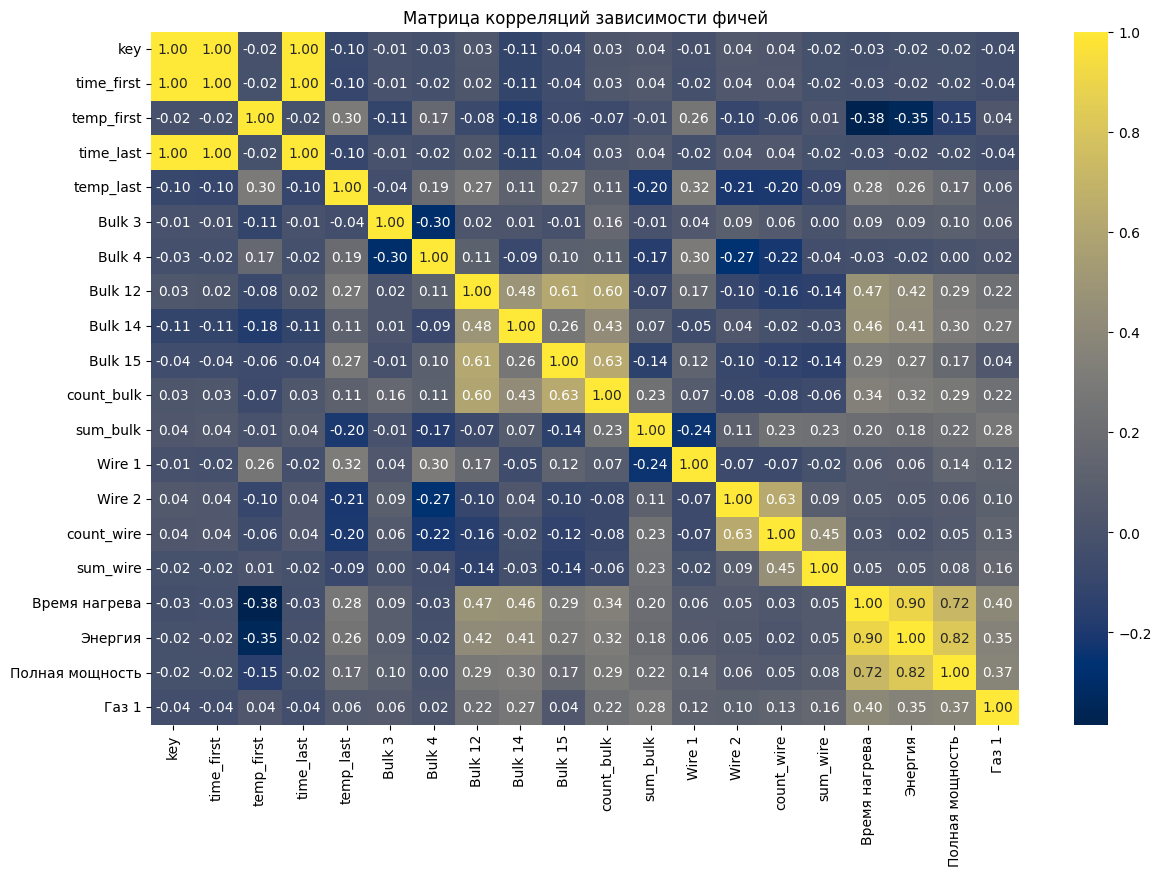

In [45]:
plt.figure(figsize=(14, 9))
plt.title('Матрица корреляций зависимости фичей')

# Ограничение количества разрядов после запятой до 2
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='cividis')

plt.show()


Из корреляционной матрицы видно, что существует сильная корреляция между следующими параметрами:

 - Время нагрева   
 - Энергия  


Поскольку эти параметры являются взаимозависимыми и мы использовали их для вычислений, перед разделением данных на тренировочный и тестовый наборы, рекомендуется удалить один или несколько из них. Остальные параметры можно оставить, так как они не имеют сильной корреляции между собой (коэффициент Пирсона менее 0.8) и могут быть полезными для модели.

Исследуем признаки полученного датафрейма с помощью графиков:

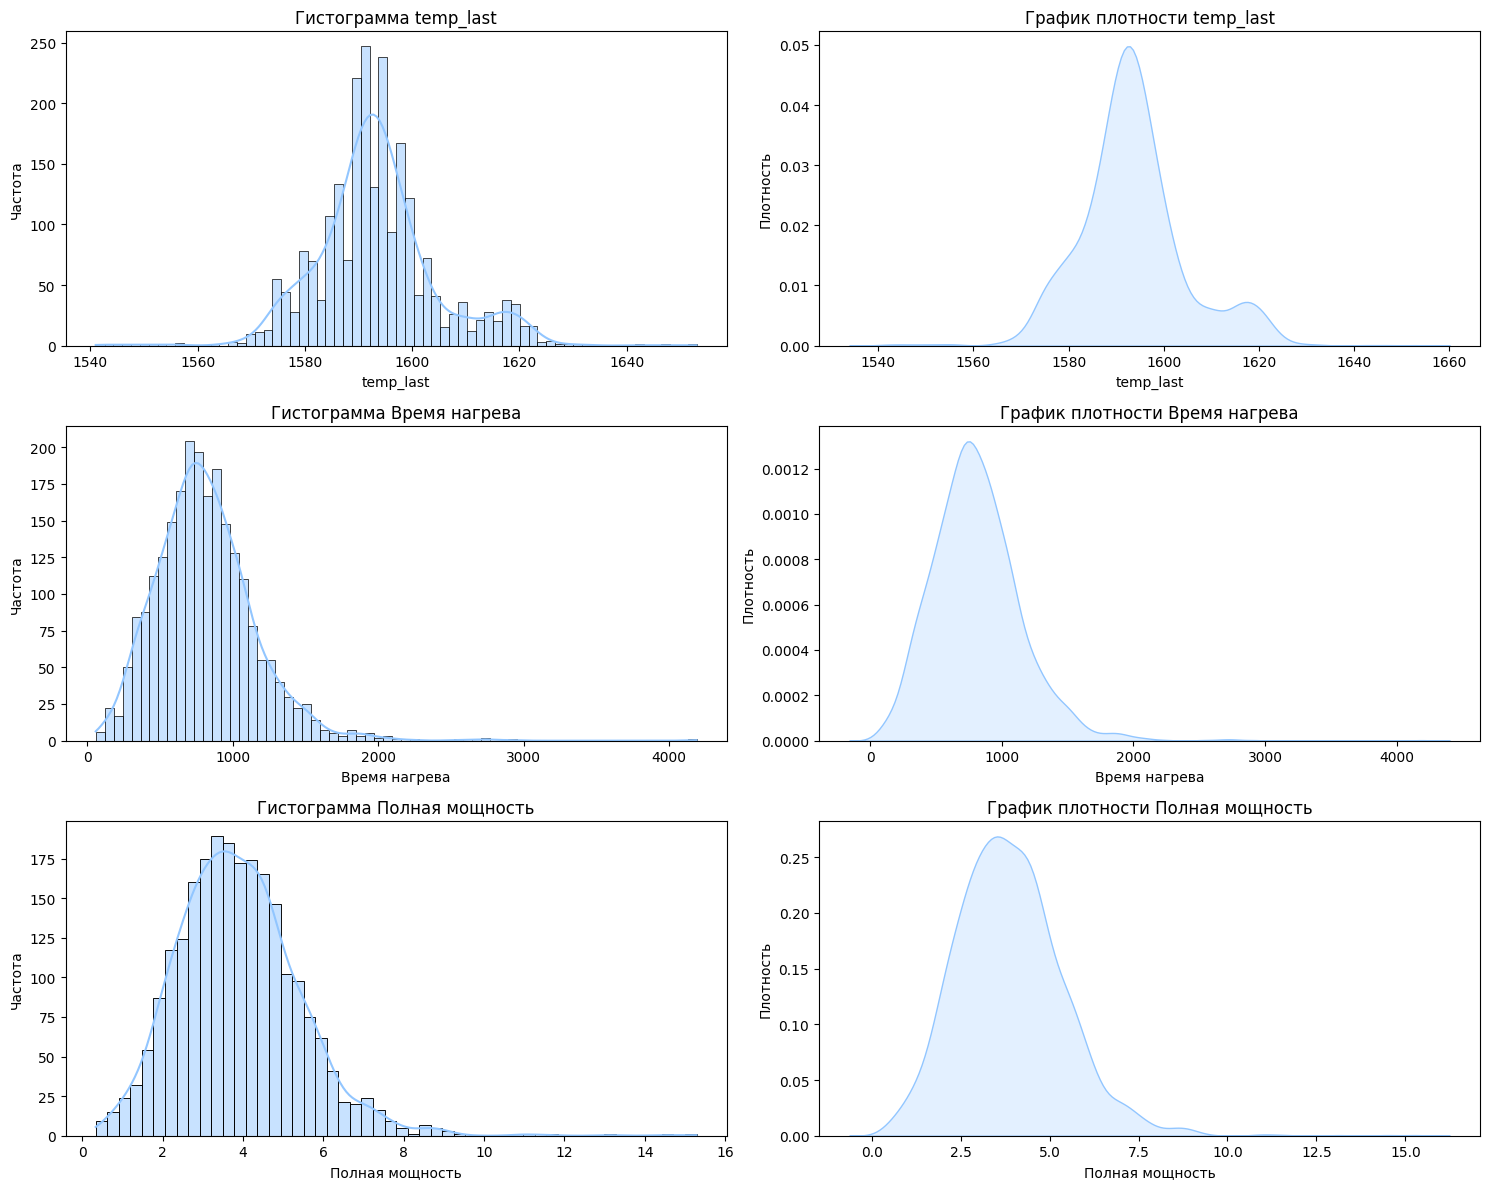

In [47]:
# Создаем фигуру
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Обозначаем признаки, которые хотим отрисовывать
selected_features = ['temp_last', 'Время нагрева', 'Полная мощность']

# Строим гистограммы и графики плотности для выбранных признаков
for i, feature in enumerate(selected_features):
    # Гистограмма
    sns.histplot(df[feature], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Гистограмма {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Частота')

    # График плотности
    sns.kdeplot(df[feature], ax=axes[i, 1], shade=True)
    axes[i, 1].set_title(f'График плотности {feature}')
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

## <a name="раздел-5.2"></a> Вывод по исследованию нового датафрейма:



***Структура данных:*** новый датафрейм содержит 2293 строки и 18 столбцов.

***Столбцы:***

 - key: Уникальный идентификатор партии стали.  
 - temp_first и temp_last: Температура на начало и конец процесса нагрева соответственно.  
 - Bulk 3, Bulk 4, Bulk 12, Bulk 14, Bulk 15: Данные о добавлении сыпучих материалов (Bulk) в партию стали.  
 - count_bulk и sum_bulk: Созданные дополнительные признаки, связанные с сыпучими материалами.  
 - Wire 1 и Wire 2: Данные о добавлении проволоки (Wire) в партию стали.  
 - count_wire и sum_wire: Созданные дополнительные признаки, связанные с проволокой.  
 - Время нагрева: Общее время нагрева в секундах.  
 - Энергия: Показатель энергии.   
 - Полная мощность: Показатель полной мощности.  
 - Газ 1: Измеренное значение газа.  


Из описательной статистики для нового датафрейма можно сделать следующие выводы:  

Среднее значение температуры в начале процесса составляет приблизительно 1587.37, с стандартным отклонением 23.63.   
Среднее значение температуры в конце процесса составляет приблизительно 1593.37, с стандартным отклонением 11.21.  
Температуры в начале и в конце процесса близки, с более высокой дисперсией для начальной температуры.    


Bulk 3, Bulk 4, Bulk 12, Bulk 14, Bulk 15:  
Эти признаки представляют собой объем добавленных материалов (Bulk) в процессе.  
Средние значения различных Bulk-материалов различаются, но обычно они находятся в диапазоне от 0 до 200.  
Присутствует значительный разброс в данных, что может потребовать дополнительной обработки.  
count_bulk и sum_bulk:  


count_bulk представляет среднее количество добавленных Bulk-материалов и имеет среднее значение около 3.59.    
sum_bulk представляет суммарное количество добавленных Bulk-материалов и имеет среднее значение около 42.79.  

Wire 1 и Wire 2:  
Эти признаки представляют собой объем добавленных проволок (Wire) в процессе.  
Средние значения различных Wire-материалов различаются, и они находятся в диапазоне от 0 до 330 для Wire 1 и от 0 до 282.78 для Wire 2.


count_wire и sum_wire:  
count_wire представляет среднее количество добавленных проволок и имеет среднее значение около 1.40.  
sum_wire представляет суммарное количество добавленных проволок и имеет среднее значение около 5.17.  

Время нагрева и Энергия:  
Время нагрева имеет среднее значение около 808.20 с стандартным отклонением около 340.81. Время нагрева может значительно варьироваться.  
Энергия имеет среднее значение около 670.23 с стандартным отклонением около 319.53. Энергия также может значительно варьироваться.  

Полная мощность и Газ 1:
Полная мощность имеет среднее значение около 3.89 с низким стандартным отклонением, что может указывать на относительно стабильную полную мощность.

Итог преобразований: новый датафрейм содержит предобработанные данные, включая заполненные и обогащенные признаки. Пропущенные значения в столбцах Bulk и Wire обработаны, и дополнительные признаки, связанные с этими данными. Также данные приведены к подходящим типам данных (например, float64 и int64). Это позволит легче использовать датафрейм для обучения модели машинного обучения.

## <a name="раздел-6"></a> Настало время выбрать оптимальную модель


Для моделирования, рассмотрим несколько деревянных моделей и бустинговые модели, основанные на дереве решений:  
 
 - Дерево решений  
 - Случайный лес  
 - LightGBM  
 - XGBoost  
 - CatBoost  

Подгрузим необходимые библиотеки:  


Разделим датасет на тренировочную и тестовую в соотношении 5 к 1, а так же предварительно перемешаем дополнительно наблюдения, так как в изначальном датасете все данные были распределены по времени:

In [49]:
df_shuffled = shuffle(df, random_state=RANDOM_STATE)

df_shuffled.info()

df_features = df_shuffled.drop(['key', 'temp_last', 'Время нагрева', 'Полная мощность'], axis=1)
df_target = df_shuffled['temp_last']

train_features, test_features, train_target, test_target = train_test_split(df_features, 
                                                                            df_target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Index: 2324 entries, 1958 to 594
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2324 non-null   int64  
 1   time_first       2324 non-null   int64  
 2   temp_first       2324 non-null   float64
 3   time_last        2324 non-null   int64  
 4   temp_last        2324 non-null   float64
 5   Bulk 3           2324 non-null   float64
 6   Bulk 4           2324 non-null   float64
 7   Bulk 12          2324 non-null   float64
 8   Bulk 14          2324 non-null   float64
 9   Bulk 15          2324 non-null   float64
 10  count_bulk       2324 non-null   int64  
 11  sum_bulk         2324 non-null   float64
 12  Wire 1           2324 non-null   float64
 13  Wire 2           2324 non-null   float64
 14  count_wire       2324 non-null   int64  
 15  sum_wire         2324 non-null   float64
 16  Время нагрева    2324 non-null   int64  
 17  Энергия          

Для нахождения оптимальных параметров модели мы создадим функцию, используя метод GridSearchCV. Этот метод позволяет нам автоматически перебирать различные комбинации параметров модели и оценивать их производительность с использованием кросс-валидации.

После запуска GridSearchCV мы получим таблицу, в которой будут отражены результаты для каждой комбинации параметров. Затем мы сможем выбрать оптимальную модель, исходя из наилучших параметров, которые обеспечивают наилучшую производительность нашей модели.

In [50]:
# Создаем пустую таблицу analisys, в которой будут храниться результаты анализа
analisys = pd.DataFrame({'model':[], 'MAE_model':[], 'MAE_on_train':[]})
# Создает пустой список all_models, в котором будут храниться обученные модели 
all_models = []
# Создаем функцию train_model, которая принимает модель (model) и словарь параметров (parameters) для настройки модели
def train_model(model, parameters):
    # Внутри функции train_model создаем объект model_random - это модель, настроенная с GridSearchCV
    model_random = GridSearchCV(estimator=model,
                                param_grid=parameters, # Используем параметры
                                scoring='neg_mean_absolute_error', # Используем необходимую метрику
                                cv=3, 
                                verbose=1)

    # Засекаем время начала обучения с помощью time()
    start = time()
    # Обучаем модель на тренировочных данных (train_features и train_target) с помощью метода fit
    model_random.fit(train_features, train_target)
    # Выводим время, затраченное на подбор параметров
    print('GridSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    # Вычисляем MAE модели на тестовой выборке (rmse) и MAE на тренировочной выборке (rmse_on_train)
    rmse = model_random.best_score_ * -1
    rmse_on_train = mean_absolute_error(train_target, model_random.predict(train_features))
    # Выводим лучшие параметры, найденные GridSearchCV, а также значения MAE 
    print('Лучшие параметры:', model_random.best_params_)
    print('MAE обученной модели:', rmse)
    print('MAE на тренировочной выборке:', rmse_on_train)
    
    # Обученную модель добавляем в список all_models
    all_models.append(model_random)
    # Создаем строка row, содержую модель
    row = []
    # Строка row добавляется в таблицу analisys
    row.extend([model, rmse, rmse_on_train])
    analisys.loc[len(analisys.index)] = row
    # Функцией train_model возвращаем обученную модель (model_random)
    return model_random

Рассмотрим модели:

DecisionTreeRegressor() - модель машинного обучения, представляющая собой регрессионное дерево решений, которое используется для задачи регрессии, то есть для прогнозирования числовых значений целевой переменной на основе входных признаков.

In [51]:
ran_grid_tree = {"max_depth": list(range(3, 12))}

dtr = DecisionTreeRegressor()

dtr_random = train_model(dtr, ran_grid_tree)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
GridSearchCV подбирал параметры 0.15 секунд
Лучшие параметры: {'max_depth': 4}
MAE обученной модели: 7.667064795804907
MAE на тренировочной выборке: 7.119895313395591


RandomForestRegressor - модель машинного обучения, представляющая собой ансамбль случайных лесов для задачи регрессии, которая объединяет несколько деревьев решений для улучшения точности прогнозирования числовых значений целевой переменной.

In [52]:
ran_grid_forest = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200, 300]
}

rfr = RandomForestRegressor(n_jobs=-1)

rfr_random = train_model(rfr, ran_grid_forest)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
GridSearchCV подбирал параметры 13.06 секунд
Лучшие параметры: {'max_depth': 8, 'n_estimators': 200}
MAE обученной модели: 6.7016710727339195
MAE на тренировочной выборке: 4.819887407460736


LGBMRegressor - модель машинного обучения, представляющая собой градиентный бустинг на основе LightGBM для задачи регрессии, обладающая высокой производительностью и способной работать с большими объемами данных.

In [53]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random = train_model(gbm, rand_lgbm_param)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
GridSearchCV подбирал параметры 12.35 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5}
MAE обученной модели: 6.810367249790294
MAE на тренировочной выборке: 4.604831984818981


XGBRegressor - модель машинного обучения, представляющая собой градиентный бустинг на основе XGBoost для задачи регрессии, известная своей эффективностью и способностью обрабатывать разнообразные данные.

In [54]:
rand_xgb_param = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True,
                     verbosity=0)

xb_random = train_model(xb, rand_xgb_param)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
GridSearchCV подбирал параметры 20.90 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 6}
MAE обученной модели: 6.652258727992326
MAE на тренировочной выборке: 3.7158496569985298



CatBoostRegressor - модель машинного обучения, представляющая собой градиентный бустинг, специально оптимизированный для работы с категориальными признаками, и широко используемый в задачах регрессии.

In [55]:
rand_cat_param = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1]
}

cat = CatBoostRegressor(verbose=False) 

cat_random = train_model(cat, rand_cat_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
GridSearchCV подбирал параметры 35.60 секунд
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 7}
MAE обученной модели: 6.603282760366381
MAE на тренировочной выборке: 5.111168089385166


Рассмотрим метрики на графиках:

In [56]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

,model,MAE_model,MAE_on_train,names
0,DecisionTreeRegressor(),7.667065,7.119895,DecisionTree
1,RandomForestRegressor(n_jobs=-1),6.701671,4.819887,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",6.810367,4.604832,LightGBM
3,"XGBRegressor(base_score=None, booster='gbtree'...",6.652259,3.715850,XGBoost
4,<catboost.core.CatBoostRegressor object at 0x1...,6.603283,5.111168,CatBoost


## <a name="раздел-6.1"></a> Итоговая модель. Вывод:

Из полученных моделей наилучше всего показала себя модель CatBoost с параметрами:    
GridSearchCV подбирал параметры 35.86 секунд  
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 7}  
MAE обученной модели: 6.603282760366381  
MAE на тренировочной выборке: 5.111168089385166  

Данную модель можно использовать в тестировании.  

## <a name="раздел-7"></a> Тестирование модели:  

Берем обученную модель и смотрим метрики на тестовой выборке:

In [57]:
predicted = cat_random.predict(test_features)
mae_on_test = mean_absolute_error(test_target, predicted)
print('MAE на тестовой выборке при использовании GridSearchCV:', mae_on_test)

MAE на тестовой выборке при использовании GridSearchCV: 6.235999033693414


График важности параметров (feature importances) представляет собой визуализацию того, насколько каждый параметр (признак) влияет на предсказания модели. Это полезный инструмент для понимания, какие признаки модель считает наиболее информативными при принятии решений.

Значения на графике показывают, насколько каждый признак важен для модели. Обычно, чем выше значение важности, тем больший вклад вносит данный признак в прогнозы модели. Это позволяет исследователям и разработчикам лучше понимать, какие факторы оказывают наибольшее влияние на результаты моделирования.

Построим график - Важность параметров:

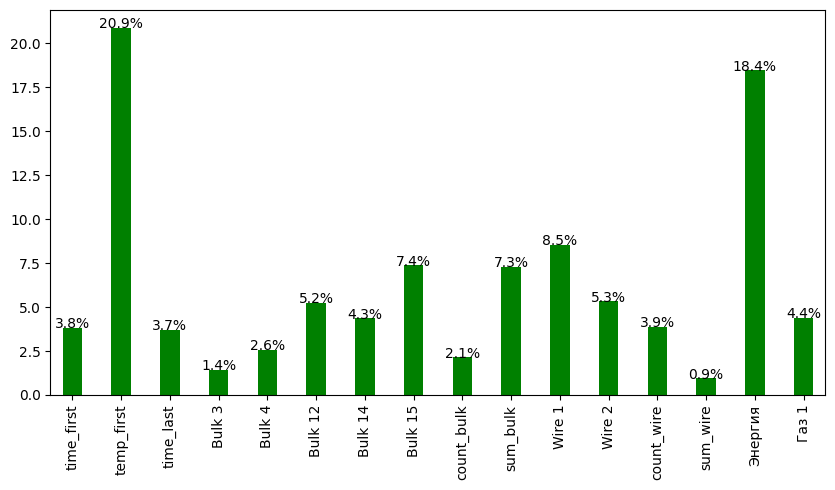

In [58]:
# Строим столбчатую диаграмму
features = pd.Series(cat_random.best_estimator_.feature_importances_, index=train_features.columns)

plt.figure(figsize=(10, 5))
ax = features.plot.bar(color='green', width=0.4)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height*1:.1f}%', (x + width/2, y + height), ha='center')

plt.show()




Константная модель (или базовая модель) - это модель машинного обучения, которая предсказывает постоянное значение для всех входных данных, независимо от самих данных. То есть, она всегда выдает одно и то же предсказание, которое является неким константным значением.

Константная модель может быть полезной для оценки производительности других моделей. Если другая модель не может предсказать результаты лучше, чем константная модель, то это может быть признаком того, что модель нуждается в доработке или оптимизации.

In [59]:
# Создаем константную модель
dummy_model = DummyRegressor(strategy="mean")
# Обучаем модель на train
dummy_model.fit(train_features, train_target)
# Предсказываем значения на test
dummy_predictions = dummy_model.predict(test_features)
# Вычисляем MAE 
mae_dummy_model = mean_absolute_error(test_target, dummy_predictions)
# Выводим MAE
print('MAE константной модели (с использованием DummyRegressor):', mae_dummy_model)

MAE константной модели (с использованием DummyRegressor): 7.625004073337862


Наша модель лучше константной, значит мы на правильном пути!

***Выводы***

- temp_first - начальная температура, оказалась самым важным параметром с важностью около 20,9%. Это может указывать на то, что начальная температура имеет большое влияние на целевую переменную.

- Wire 1 - количество проволоки 1, оказалось вторым по важности параметром с важностью около 8,5%. 

- Энергия - энергия, затраченная на процесс, также имеет высокую важность около 18,4%. Это говорит о том, что затраты энергии так же играют существенную роль в предсказании целевой переменной.

- Bulk 15 - объем добавления материала Bulk 15, оказался четвертым по важности параметром с важностью около 7,4%. Это может указывать на важность объема этого материала в процессе.

- sum_bulk - суммарный объем добавленных материалов Bulk, также имеет значительное влияние с важностью около 7.3%. Это говорит о коллективном воздействии различных материалов Bulk на целевую переменную.


## <a name="раздел-8"></a> Отчет по проекту:  
***Сравнение решения и плана***  
Проект был запланирован следующим образом:  
Подготовка данных.  
Обучение нескольких моделей машинного обучения.  
Оценка моделей и выбор лучшей.  
Тестирование лучшей модели на тестовых данных.  
Анализ важности признаков.  
В целом, план был выполнен, но некоторые отклонения имели место быть. Основное отличие - расширенный анализ важности признаков, который оказался более обстоятельным, чем изначально планировалось.  
***Описание трудностей проекта и их решение***    
Главной трудностью было правильное выбор оптимальной модели и ее параметров, учитывая большое количество признаков и нелинейность данных. Это было преодолено путем применения GridSearchCV для настройки параметров моделей и кросс-валидации для более точной оценки производительности моделей.  
***Описание ключевых шагов решения***   
Подготовка данных:   
Объединение данных из разных источников (склейка).   
Предобработка данных, включая удаление ненужных признаков и обработку пропущенных значений.  
Обучение моделей:  
Использование нескольких моделей машинного обучения: Дерево решений, Случайный лес, LightGBM, XGBoost, и CatBoost.  
Настройка гиперпараметров с использованием GridSearchCV.  
Выбор лучшей модели:  
Оценка моделей по метрике MAE (средняя абсолютная ошибка) и выбор наилучшей модели.  
Тестирование лучшей модели:  
Проверка производительности выбранной модели на тестовых данных.  
Анализ важности признаков:  
Оценка влияния различных признаков на результаты модели.  
***Признаки, которые использовали для обучения и их предобработка***  
Использованные признаки:  
temp_first: начальная температура.  
Wire 1: количество проволоки 1.  
Энергия: энергия, затраченная на процесс.  
Bulk 15: объем добавления материала Bulk 15.  
sum_bulk: суммарный объем добавленных материалов Bulk.  
Предобработка данных включала в себя удаление ненужных признаков, обработку пропущенных значений и разделение данных на тренировочный и тестовый наборы. 
***Полное описание модели:***  
Выбранная модель: CatBoostRegressor  
Оптимальные гиперпараметры:  
learning_rate: 0.01  
max_depth: 7  
***Итоговая метрика***  
MAE (средняя абсолютная ошибка) на тестовой выборке при использовании выбранной модели CatBoostRegressor составляет примерно 6.24.  
***Рекомендации по улучшению решения***
Для улучшения решения можно рассмотреть следующие аспекты:  
- Попробовать другие алгоритмы машинного обучения и ансамбли моделей.
- Улучшить предобработку данных, учитывая особенности каждого признака и возможные выбросы.
- Рассмотреть возможность использования временных рядов для прогнозирования температуры.
- Расширить объем данных для обучения модели, если это возможно.
